# Business Problem:

## Background

Every year, the federal government releases large amounts of data on U.S. schools, school districts, and colleges. But this information is scattered across multiple datasets that are often difficult to access, and changes in data structure complicate efforts to measure change over time. The Urban Institute (https://educationdata.urban.org/documentation/index.html) has organized and consolidated this data to make it easier to combine data from different reporting sources.

Using the Urban institutes consolidated data platform we will be combining datasets describing characteristics and metrics of individual schools with data describing characteristics at the school district level.

We will use this data to build a classification model which classifies high schools as either having a low or high graduation rate. The distinction between low and high graduation rates is based on the federal government's standard that those schools with less than two thirds of class graduating are low graduation rate schools.

## Limitations



- Year: For our examination we only used data from 2015 as this year was the most data rich across district and school datasets
- Our data is limited to only those schools which reported their graduation rates

## Problem Statement

Predict which schools have high and which schools have low high school graduation rates. Identify which characteristics are the best indicator of high and low graduation rates so that school districts know where to focus resources when attempting to increase high school graduation rates.

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtic
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import catboost
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from catboost import Pool, sum_models
from catboost import CatBoostClassifier
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, balanced_accuracy_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,  OneHotEncoder, MinMaxScaler, StandardScaler 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, truncnorm, randint

# Data Exploration and Prep

Our school level data contains information on the school location, degree of urbanization, school size, number of students proficient in math and reading assessments, number of allegations for harassment/bullying, number of students enrolled in specific subjects, number of disciplinary actions taken, and number of students participation in ACT/SAT tests.

Our district level data contains financial information for each school district. This includes type and amount of capital outlays, debt outstanding at the end of the fiscal year, district expenditures, and revenue. District data also includes number of English language learners, employee benefits, and salary for instruction. 

## Data Load

In [2]:
#Northeastern United States school and district data
df_school_northeast = pd.read_csv('data/EducationDataPortal_schools_northeast.csv')
df_district_northeast = pd.read_csv('data/EducationDataPortal_districts_northeast.csv')

In [3]:
#Western United States school and district data
df_school_west = pd.read_csv('data/EducationDataPortal_schools_west.csv')
df_district_west = pd.read_csv('data/EducationDataPortal_districts_west.csv')

In [4]:
#Midwest United States school and district data
df_school_midwest = pd.read_csv('data/EducationDataPortal_schools_midwest.csv')
df_district_midwest = pd.read_csv('data/EducationDataPortal_districts_midwest.csv')

In [5]:
#Southern Atlantic United States school and district data
df_school_south_atl = pd.read_csv('data/EducationDataPortal_schools_south_atl.csv')
df_district_south_atl = pd.read_csv('data/EducationDataPortal_districts_south_atl.csv')

In [6]:
#Southern Central United States school and district data
df_school_south_central = pd.read_csv('data/EducationDataPortal_schools_south_central.csv')
df_district_south_central = pd.read_csv('data/EducationDataPortal_districts_south_central.csv')

In [7]:
dataframes_school  = ['df_school_northeast','df_school_west', 'df_school_midwest', 
                      'df_school_south_atl', 'df_school_south']

In [8]:
dataframes_district  = ['df_district_northeast','df_district_west', 'df_district_midwest', 
                        'df_district_south_atl', 'df_district_south']

## Functions

In [9]:
# Returns the percentage of values in a dataframe that are nulls
def percent_null_df (df,str_name):
    count_null = df.isnull().sum().sum()
    count_non_null = df.count().sum()
    return 'percent of nulls in '+ str_name +' is '+str(int((count_null/(count_null + count_non_null))*100))+'%'
    

## df_school

In [10]:
#Concatenate school info for all three states into one dataframe
df_school = pd.concat([df_school_northeast, df_school_south_atl, 
                       df_school_midwest, df_school_west, df_school_south_central])

In [11]:
df_school['state_name'].value_counts(normalize=True, dropna=False)

California              0.106093
Texas                   0.079240
New York                0.050044
Ohio                    0.042281
Minnesota               0.039498
Michigan                0.038619
Illinois                0.036422
Pennsylvania            0.032907
Arizona                 0.032028
Florida                 0.031882
Washington              0.027585
Missouri                0.027341
Wisconsin               0.024558
North Carolina          0.024558
New Jersey              0.022947
Oklahoma                0.022752
Georgia                 0.019969
Indiana                 0.018455
Tennessee               0.017479
Alabama                 0.017430
Colorado                0.016698
Massachusetts           0.016698
Connecticut             0.015916
Kentucky                0.015623
Iowa                    0.015477
Virginia                0.015233
Kansas                  0.015038
Arkansas                0.014842
Mississippi             0.014501
Nebraska                0.013573
South Caro

In [12]:
df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False)

97     0.106288
NaN    0.104726
92     0.091593
95     0.082219
90     0.061664
         ...   
35     0.000098
23     0.000049
26     0.000049
16     0.000049
20     0.000049
Name: grad_rate_midpt, Length: 99, dtype: float64

In [13]:
df_school

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,2015,90000201136,A. I. Prince Technical High School,Connecticut,Connecticut Technical High Sc,6106,"City, midsize",High,Vocational school,No,...,212.0,66.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0
1,2015,90000201137,Bullard-Havens Technical High School,Connecticut,Connecticut Technical High Sc,6610,"City, midsize",High,Vocational school,No,...,180.0,NaN,207.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0
2,2015,90000201138,E. C. Goodwin Technical High School,Connecticut,Connecticut Technical High Sc,6053,"Suburb, large",High,Vocational school,No,...,308.0,45.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,209.0
3,2015,90000201139,Ella T. Grasso Southeastern Technical High School,Connecticut,Connecticut Technical High Sc,6340,"Rural, fringe",High,Vocational school,No,...,165.0,35.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0
4,2015,90000201140,Eli Whitney Technical High School,Connecticut,Connecticut Technical High Sc,6514,"Suburb, large",High,Vocational school,No,...,150.0,NaN,147.0,0.0,0.0,0.0,0.0,0.0,0.0,171.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3962,2015,484668006496,DEL VALLE H S,Texas,YSLETA ISD,79907,"City, large",High,Regular school,No,...,556.0,466.0,391.0,0.0,4.0,0.0,0.0,12.0,0.0,404.0
3963,2015,484668008548,PLATO ACADEMY,Texas,YSLETA ISD,79907,"City, large",High,Other/alternative school,No,...,16.0,37.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3964,2015,484668011982,VALLE VERDE EARLY COLLEGE H S,Texas,YSLETA ISD,79915,"City, large",High,Regular school,No,...,106.0,133.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0
3965,2015,484671005351,ZAPATA H S,Texas,ZAPATA COUNTY ISD,78076,"Rural, fringe",High,Regular school,No,...,267.0,228.0,278.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0


### Data Fields

In [14]:
df_school.head()

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,2015,90000201136,A. I. Prince Technical High School,Connecticut,Connecticut Technical High Sc,6106,"City, midsize",High,Vocational school,No,...,212.0,66.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0
1,2015,90000201137,Bullard-Havens Technical High School,Connecticut,Connecticut Technical High Sc,6610,"City, midsize",High,Vocational school,No,...,180.0,NaN,207.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0
2,2015,90000201138,E. C. Goodwin Technical High School,Connecticut,Connecticut Technical High Sc,6053,"Suburb, large",High,Vocational school,No,...,308.0,45.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,209.0
3,2015,90000201139,Ella T. Grasso Southeastern Technical High School,Connecticut,Connecticut Technical High Sc,6340,"Rural, fringe",High,Vocational school,No,...,165.0,35.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0
4,2015,90000201140,Eli Whitney Technical High School,Connecticut,Connecticut Technical High Sc,6514,"Suburb, large",High,Vocational school,No,...,150.0,NaN,147.0,0.0,0.0,0.0,0.0,0.0,0.0,171.0


In [15]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20482 entries, 0 to 3966
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             20482 non-null  int64  
 1   ncessch                          20482 non-null  int64  
 2   school_name                      20482 non-null  object 
 3   state_name                       20482 non-null  object 
 4   lea_name                         20482 non-null  object 
 5   zip_location                     20482 non-null  object 
 6   urban_centric_locale             20457 non-null  object 
 7   school_level                     20482 non-null  object 
 8   school_type                      20482 non-null  object 
 9   charter                          20482 non-null  object 
 10  enrollment                       20482 non-null  object 
 11  read_test_num_valid              18073 non-null  float64
 12  read_test_pct_prof_

In [16]:
df_school.shape

(20482, 64)

#### Data Field Cleanup

In [17]:
column_names = list(df_school.columns)

In [18]:
for c in column_names:
    df_school[c].replace('Suppressed data', np.NaN,inplace =True)

In [19]:
for c in column_names:
    df_school[c].replace('Not applicable', np.NaN,inplace =True)

In [20]:
for c in column_names:
    df_school[c].replace('Missing/not reported', np.NaN,inplace =True)

### Columns to drop

In [21]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20482 entries, 0 to 3966
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             20482 non-null  int64  
 1   ncessch                          20482 non-null  int64  
 2   school_name                      20482 non-null  object 
 3   state_name                       20482 non-null  object 
 4   lea_name                         20482 non-null  object 
 5   zip_location                     19473 non-null  object 
 6   urban_centric_locale             20457 non-null  object 
 7   school_level                     20482 non-null  object 
 8   school_type                      20482 non-null  object 
 9   charter                          19368 non-null  object 
 10  enrollment                       20001 non-null  object 
 11  read_test_num_valid              18073 non-null  float64
 12  read_test_pct_prof_

In [22]:
df_school['corpinstances_preschool'].value_counts(normalize=True, dropna=False)

-1.0    0.904355
 NaN    0.094376
 0.0    0.001221
 3.0    0.000049
Name: corpinstances_preschool, dtype: float64

In [23]:
df_school['students_corporal_punish'].value_counts(normalize=True, dropna=False)

NaN     0.953423
0       0.007714
2       0.005908
4       0.003955
6       0.002246
          ...   
78      0.000049
171     0.000049
1653    0.000049
111     0.000049
120     0.000049
Name: students_corporal_punish, Length: 116, dtype: float64

- Drop year as this is the same for all rows
- Drop corpinstances_preschool this column is mostly -1 which is not interpretable

In [24]:
df_school = df_school.drop(['year','corpinstances_preschool','students_corporal_punish','zip_location'], axis=1)

### school_type

In [25]:
df_school['school_type'].value_counts(normalize=True, dropna=False)

Regular school              0.798994
Other/alternative school    0.136559
Vocational school           0.050337
Special education school    0.014110
Name: school_type, dtype: float64

In [26]:
df_school_regular = df_school.loc[df_school['school_type'] == 'Regular school']
df_school_regular

,ncessch,school_name,state_name,lea_name,urban_centric_locale,school_level,school_type,charter,enrollment,read_test_num_valid,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
32,90000401360,Walter G. Cady School,Connecticut,UNIFIED SCHOOL DISTRICT #2,"City, small",High,Regular school,No,62,3.0,...,31.0,NaN,31.0,5.0,12.0,0.0,5.0,9.0,0.0,0.0
33,90000501215,E. O. Smith High School,Connecticut,REGIONAL SCHOOL DISTRICT 19,"Suburb, large",High,Regular school,No,1153,260.0,...,264.0,120.0,237.0,0.0,0.0,0.0,0.0,0.0,0.0,420.0
36,90001400807,Common Ground High School,Connecticut,COMMON GROUND HIGH SCHOOL DIS,"City, midsize",High,Regular school,Yes,186,39.0,...,37.0,18.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0
37,90001500809,The Bridge Academy,Connecticut,THE BRIDGE ACADEMY DISTRICT,"City, midsize",High,Regular school,Yes,279,139.0,...,46.0,NaN,50.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0
38,90001800834,Explorations,Connecticut,EXPLORATIONS DISTRICT,"Town, fringe",High,Regular school,Yes,92,21.0,...,14.0,NaN,10.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3960,484668005347,YSLETA H S,Texas,YSLETA ISD,"City, large",High,Regular school,No,1337,966.0,...,320.0,347.0,NaN,0.0,3.0,0.0,0.0,4.0,0.0,347.0
3962,484668006496,DEL VALLE H S,Texas,YSLETA ISD,"City, large",High,Regular school,No,1923,1259.0,...,556.0,466.0,391.0,0.0,4.0,0.0,0.0,12.0,0.0,404.0
3964,484668011982,VALLE VERDE EARLY COLLEGE H S,Texas,YSLETA ISD,"City, large",High,Regular school,No,407,223.0,...,106.0,133.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0
3965,484671005351,ZAPATA H S,Texas,ZAPATA COUNTY ISD,"Rural, fringe",High,Regular school,No,987,823.0,...,267.0,228.0,278.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0


In [27]:
df_school_alternative = df_school.loc[df_school['school_type'] == 'Other/alternative school']
df_school_alternative

,ncessch,school_name,state_name,lea_name,urban_centric_locale,school_level,school_type,charter,enrollment,read_test_num_valid,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
16,90000300343,Bridgeport Correctional Center,Connecticut,UNIFIED SCHOOL DISTRICT #1,"City, midsize",High,Other/alternative school,No,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,90000300344,Brooklyn Correctional Institution,Connecticut,UNIFIED SCHOOL DISTRICT #1,"Rural, fringe",High,Other/alternative school,No,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,90000300347,Cheshire Correctional Institution,Connecticut,UNIFIED SCHOOL DISTRICT #1,"Suburb, large",High,Other/alternative school,No,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,90000300361,Hartford Correctional Center,Connecticut,UNIFIED SCHOOL DISTRICT #1,"City, midsize",High,Other/alternative school,No,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,90000300374,New Haven Correctional Center,Connecticut,UNIFIED SCHOOL DISTRICT #1,"City, midsize",High,Other/alternative school,No,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,484578000736,HARRELL ACCELERATED LEARNING CENTER,Texas,WICHITA FALLS ISD,"City, midsize",High,Other/alternative school,No,79,64.0,...,31.0,31.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3936,484578009422,WICHITA COUNTY JUVENILE JUSTICE AEP,Texas,WICHITA FALLS ISD,"City, midsize",High,Other/alternative school,No,27,29.0,...,NaN,NaN,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3954,484668003897,CESAR CHAVEZ ACADEMY,Texas,YSLETA ISD,"City, large",High,Other/alternative school,No,68,NaN,...,13.0,13.0,24.0,0.0,2.0,0.0,0.0,8.0,0.0,7.0
3961,484668005938,TEJAS SCHOOL OF CHOICE,Texas,YSLETA ISD,"City, large",High,Other/alternative school,No,102,101.0,...,36.0,54.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


In [28]:
df_school_vocational = df_school.loc[df_school['school_type'] == 'Vocational school']
df_school_vocational.head(10)

,ncessch,school_name,state_name,lea_name,urban_centric_locale,school_level,school_type,charter,enrollment,read_test_num_valid,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,90000201136,A. I. Prince Technical High School,Connecticut,Connecticut Technical High Sc,"City, midsize",High,Vocational school,No,768,169.0,...,212.0,66.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0
1,90000201137,Bullard-Havens Technical High School,Connecticut,Connecticut Technical High Sc,"City, midsize",High,Vocational school,No,784,174.0,...,180.0,NaN,207.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0
2,90000201138,E. C. Goodwin Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,636,141.0,...,308.0,45.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,209.0
3,90000201139,Ella T. Grasso Southeastern Technical High School,Connecticut,Connecticut Technical High Sc,"Rural, fringe",High,Vocational school,No,505,125.0,...,165.0,35.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0
4,90000201140,Eli Whitney Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,551,140.0,...,150.0,NaN,147.0,0.0,0.0,0.0,0.0,0.0,0.0,171.0
5,90000201141,Emmett OBrien Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,573,131.0,...,134.0,69.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,219.0
6,90000201142,H. C. Wilcox Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,760,188.0,...,191.0,141.0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,270.0
7,90000201143,H. H. Ellis Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,623,154.0,...,329.0,NaN,119.0,0.0,0.0,0.0,0.0,0.0,0.0,184.0
8,90000201144,Henry Abbott Technical High School,Connecticut,Connecticut Technical High Sc,"City, small",High,Vocational school,No,640,145.0,...,173.0,93.0,172.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0
9,90000201145,Howell Cheney Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,653,148.0,...,182.0,19.0,153.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0


In [29]:
df_school_special = df_school.loc[df_school['school_type'] == 'Special education school']
df_school_special.head(10)

,ncessch,school_name,state_name,lea_name,urban_centric_locale,school_level,school_type,charter,enrollment,read_test_num_valid,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
46,90007001588,Center for Autism Spectrum and Development Dis...,Connecticut,AREA COOPERATIVE EDUCATIONAL,"Suburb, large",High,Special education school,No,38,NaN,...,NaN,NaN,NaN,0.0,58.0,150.0,0.0,14.0,16.0,0.0
64,90051001515,Community/Vocational Program,Connecticut,BRISTOL SCHOOL DISTRICT,"Suburb, large",High,Special education school,No,12,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,90070001567,Lincoln Academy Regional Interdistrict Collabo...,Connecticut,CAPITOL REGION EDUCATION COUN,"City, small",High,Special education school,No,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,90070001693,Soundbridge @ Wethersfield High School,Connecticut,CAPITOL REGION EDUCATION COUN,"Suburb, large",High,Special education school,No,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,90070001802,STRIVE (Southern Transition Real-World and Ind...,Connecticut,CAPITOL REGION EDUCATION COUN,"Suburb, large",High,Special education school,No,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,90075001766,Cheshire Quinnipiac University Transition Coll...,Connecticut,CHESHIRE SCHOOL DISTRICT,"Suburb, large",High,Special education school,No,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,90123001514,The Learning Center at East Hampton,Connecticut,EAST HAMPTON SCHOOL DISTRICT,"Town, fringe",High,Special education school,No,6,NaN,...,NaN,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,90132001730,Post High School Transition Program,Connecticut,EAST LYME SCHOOL DISTRICT,"Suburb, midsize",High,Special education school,No,16,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,90132001843,Medically Fragile Program (WAVES),Connecticut,EAST LYME SCHOOL DISTRICT,NaN,High,Special education school,No,2,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,90147001523,Enfield Transitional Learning Academy,Connecticut,ENFIELD SCHOOL DISTRICT,"Suburb, large",High,Special education school,No,6,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#Proportion of nulls regular school type
percent_null_df(df_school_regular,'df_school_regular')

'percent of nulls in df_school_regular is 4%'

In [31]:
#Proportion of nulls vocational school type
percent_null_df(df_school_vocational,'df_school_vocational')

'percent of nulls in df_school_vocational is 61%'

In [32]:
#Proportion of nulls alternative school type
percent_null_df(df_school_alternative,'df_school_alternative')

'percent of nulls in df_school_alternative is 24%'

In [33]:
#Proportion of nulls special education school type
percent_null_df(df_school_special,'df_school_special')

'percent of nulls in df_school_special is 38%'

Our Other/alternative school in the school_type field includes jails and detention centers. Many of these correctional facilities have a lot of NaN values in other data fields. We will remove all rows with alternative schools since there seems to be many missing values for these types of schools and because students in these types of schools are experiencing circumstances and educational experiences very different from the majority of students.

We will also remove vocational and special education school types as these school types are a small percentage of the data and have high proportion of nulls

In [34]:
df_school.shape[0]

20482

In [35]:
df_school = df_school.loc[df_school['school_type'] == 'Regular school']
df_school.shape[0]

16365

### Graduation Rate - format the target

- The graduation rates are numerical values separated into three columns.
 - grad_rate_high
 - grad_rate_midpt 
 - grad_rate_low
 
- Looking at the data documentation from EDFacts https://www2.ed.gov/about/inits/ed/edfacts/index.htmlThe we see that the reason for multiple columns is that some schools choose to report graduation rates in a range so that student privacy is protected. The range creates a low and a high column with the midpoint being the value in the middle of the low and high values.
- We will use grad_rate_midpt to measure graduation rates as this is the most balanced.


- The federal government defines graduation rates as low when less than 2/3 of a cohort receive a diploma in 4 years or less.  
- We will classify high schools with midpoint graduation rates 66 and below as low and high schools with midpoint graduation rates of 67 and above as high.


In [36]:
#Let's see a few examples of the grad rate reporting range before we drop the high and low cols
grad_rate_cols = ['school_name','cohort_num','grad_rate_high','grad_rate_midpt',
                  'grad_rate_low']

In [37]:
df_school[grad_rate_cols].head(10)

,school_name,cohort_num,grad_rate_high,grad_rate_midpt,grad_rate_low
32,Walter G. Cady School,NaN,NaN,NaN,NaN
33,E. O. Smith High School,255.0,95,95,95
36,Common Ground High School,34.0,100,95,90
37,The Bridge Academy,34.0,79,74,70
38,Explorations,27.0,79,69,60
39,Connecticut Valley Hospital,NaN,NaN,NaN,NaN
40,Stamford Academy,53.0,29,24,20
42,Ansonia High School,125.0,89,87,85
47,Avon High School,239.0,97,97,97
48,Berlin High School,248.0,95,95,95


In [38]:
df_school = df_school.drop(['grad_rate_high','grad_rate_low'], axis=1)

In [39]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16365 entries, 32 to 3966
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          16365 non-null  int64  
 1   school_name                      16365 non-null  object 
 2   state_name                       16365 non-null  object 
 3   lea_name                         16365 non-null  object 
 4   urban_centric_locale             16364 non-null  object 
 5   school_level                     16365 non-null  object 
 6   school_type                      16365 non-null  object 
 7   charter                          15404 non-null  object 
 8   enrollment                       16328 non-null  object 
 9   read_test_num_valid              15747 non-null  float64
 10  read_test_pct_prof_low           15500 non-null  object 
 11  read_test_pct_prof_high          15500 non-null  object 
 12  read_test_pct_prof

In [40]:
df_school.update(df_school[['grad_rate_midpt']].fillna(0))

In [41]:
df_school['grad_rate_midpt'].value_counts(normalize=True,dropna=False)

97    0.127345
92    0.112679
95    0.100214
90    0.073816
87    0.071983
        ...   
25    0.000061
38    0.000061
0     0.000061
18    0.000061
23    0.000061
Name: grad_rate_midpt, Length: 92, dtype: float64

In [42]:
df_school.shape

(16365, 58)

In [43]:
19198*(1-.43)

10942.86

In [44]:
df_school = df_school[df_school.grad_rate_midpt != 0]

In [45]:
df_school.shape[0]

15830

In [46]:
# convert grad rate columns to numeric
df_school[['grad_rate_midpt']] = df_school[['grad_rate_midpt']].astype(str).astype(float).astype(int)


In [47]:
# Let's take a look at the summary statistics for the grad_rate_midpt column

print(df_school['grad_rate_midpt'].describe())


count    15830.000000
mean        85.590587
std         15.379323
min          0.000000
25%         82.000000
50%         90.000000
75%         95.000000
max         99.000000
Name: grad_rate_midpt, dtype: float64


In [48]:
 print('grad_rate_midpt', '\n', df_school['grad_rate_midpt'].value_counts(normalize=True).head(), '\n\n')

grad_rate_midpt 
 97    0.131649
92    0.116488
95    0.103601
90    0.076311
87    0.074416
Name: grad_rate_midpt, dtype: float64 




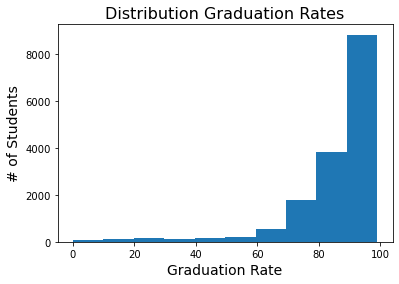

In [49]:
# Plot of the target status group

plt.hist(df_school['grad_rate_midpt'])
plt.xlabel('Graduation Rate', fontsize=14)
plt.ylabel('# of Students', fontsize=14)
plt.title("Distribution Graduation Rates", fontsize=16)
plt.show()


It looks like there is a strong skew towards higher performing high schools. Lets go ahead and bin our values and then take a look at the distribution again.

#### Bin the target

As stated above based on how the federal government defines low graduation rates we will be dividing graduation rates into two bins:
- Low: 66 and below
- High: 67 and above

In [50]:
#Based on the federal government's definition we will define the bin ranges.
grad_rate_bins = [0,66,100]

In [51]:
# now lets convert the grad_rate_midpt column to binned categories
# note that when binning these, the default setting is that the values on the right are included in the bin

df_school['grad_rate_midpt'] = pd.cut(df_school['grad_rate_midpt'], grad_rate_bins)

In [52]:
# and we will also take a look at the distribution across bins 
print(df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False))

(66.0, 100.0]    0.931522
(0.0, 66.0]      0.068414
NaN              0.000063
Name: grad_rate_midpt, dtype: float64


In [53]:
df_school = df_school.dropna(subset=['grad_rate_midpt'])
df_school.shape

(15829, 58)

In [54]:
print(df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False))

(66, 100]    0.931581
(0, 66]      0.068419
Name: grad_rate_midpt, dtype: float64


In [55]:
# We will need to address this class imbalance


#### Encode the target

In [56]:
df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False)

(66, 100]    0.931581
(0, 66]      0.068419
Name: grad_rate_midpt, dtype: float64

In [57]:
 df_school['grad_rate_midpt'] = df_school['grad_rate_midpt'].astype(str)

In [58]:
df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False)

(66, 100]    0.931581
(0, 66]      0.068419
Name: grad_rate_midpt, dtype: float64

In [59]:
 df_school['grad_rate_midpt'] = df_school['grad_rate_midpt'].replace('(0, 66]', 1)

In [60]:
 df_school['grad_rate_midpt'] = df_school['grad_rate_midpt'].replace('(66, 100]', 0)

### subject enrollment - drop all enrl columns

In [61]:
#Let's look at how many nulls we are dealing with now
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 3%'

In [62]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15829 entries, 33 to 3966
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          15829 non-null  int64  
 1   school_name                      15829 non-null  object 
 2   state_name                       15829 non-null  object 
 3   lea_name                         15829 non-null  object 
 4   urban_centric_locale             15829 non-null  object 
 5   school_level                     15829 non-null  object 
 6   school_type                      15829 non-null  object 
 7   charter                          14910 non-null  object 
 8   enrollment                       15822 non-null  object 
 9   read_test_num_valid              15478 non-null  float64
 10  read_test_pct_prof_low           15305 non-null  object 
 11  read_test_pct_prof_high          15305 non-null  object 
 12  read_test_pct_prof

The class subject enrollment columns stand out as having the most null values let's drop those columns.

In [63]:
df_school = df_school.drop(['enrl_biology', 'enrl_chemistry','enrl_advanced_math',
                            'enrl_calculus','enrl_algebra2','enrl_physics',
                            'enrl_geometry'], axis=1)

In [64]:
#How do our nulls look
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 1%'

### Encode Charter

In [65]:
df_school['charter'].value_counts(normalize=True, dropna=False)

No     0.872386
Yes    0.069556
NaN    0.058058
Name: charter, dtype: float64

In [66]:
 df_school['charter'] = df_school['charter'].replace('No', 0)

In [67]:
 df_school['charter'] = df_school['charter'].replace('Yes', 1)

In [68]:
df_school['charter'].value_counts(normalize=True, dropna=False)

0.0    0.872386
1.0    0.069556
NaN    0.058058
Name: charter, dtype: float64

We will group the small proportion of NaN values with the majority class which is zero or a non charter school.

In [69]:
df_school.update(df_school[['charter']].fillna(0))

### Reading and Math Tests

In [70]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15829 entries, 33 to 3966
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          15829 non-null  int64  
 1   school_name                      15829 non-null  object 
 2   state_name                       15829 non-null  object 
 3   lea_name                         15829 non-null  object 
 4   urban_centric_locale             15829 non-null  object 
 5   school_level                     15829 non-null  object 
 6   school_type                      15829 non-null  object 
 7   charter                          15829 non-null  float64
 8   enrollment                       15822 non-null  object 
 9   read_test_num_valid              15478 non-null  float64
 10  read_test_pct_prof_low           15305 non-null  object 
 11  read_test_pct_prof_high          15305 non-null  object 
 12  read_test_pct_prof

In [71]:
read_test = ['school_name', 'read_test_num_valid', 'read_test_pct_prof_low', 
             'read_test_pct_prof_high', 'read_test_pct_prof_midpt']

In [72]:
df_school[read_test].head(20)

,school_name,read_test_num_valid,read_test_pct_prof_low,read_test_pct_prof_high,read_test_pct_prof_midpt
33,E. O. Smith High School,260.0,82,82,82
36,Common Ground High School,39.0,30,39,34.5
37,The Bridge Academy,139.0,20,24,22
38,Explorations,21.0,21,39,30
40,Stamford Academy,25.0,0,20,10
42,Ansonia High School,137.0,50,54,52
47,Avon High School,244.0,90,90,90
48,Berlin High School,231.0,74,74,74
49,Path Academy,6.0,0,49,24.5
50,Bethel High School,199.0,75,79,77


In [73]:
math_test = ['school_name', 'math_test_num_valid' , 'math_test_pct_prof_low', 
             'math_test_pct_prof_high', 'math_test_pct_prof_midpt']

In [74]:
df_school[math_test].head(20)

,school_name,math_test_num_valid,math_test_pct_prof_low,math_test_pct_prof_high,math_test_pct_prof_midpt
33,E. O. Smith High School,260.0,55,55,55
36,Common Ground High School,39.0,0,10,5
37,The Bridge Academy,139.0,6,9,7.5
38,Explorations,21.0,0,20,10
40,Stamford Academy,25.0,0,20,10
42,Ansonia High School,137.0,20,24,22
47,Avon High School,246.0,77,77,77
48,Berlin High School,231.0,49,49,49
49,Path Academy,6.0,0,49,24.5
50,Bethel High School,199.0,55,59,57


The read_test_num_valid column and the math_test_num_valid column desribe the Number of students who completed a reading, and math assessment and for whom a proficiency level was assigned

The low, high, and midpt columns describe the low, high, and midpoint of the range used to report the share of students scoring proficient on a reading or language arts assessment (0–100 scale)



In [75]:
# The midpoint column is the most balanced measure so we will drop the others
df_school = df_school.drop(['math_test_pct_prof_low','math_test_pct_prof_high',
                           'read_test_pct_prof_low','read_test_pct_prof_high'], axis=1)

### Numeric Columns - nulls

Let's take a look at our columns and check back in on the proportion of nulls. If our proportion is small we will fill the NaNs in the remaining numerical columns with medians.

In [76]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15829 entries, 33 to 3966
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          15829 non-null  int64  
 1   school_name                      15829 non-null  object 
 2   state_name                       15829 non-null  object 
 3   lea_name                         15829 non-null  object 
 4   urban_centric_locale             15829 non-null  object 
 5   school_level                     15829 non-null  object 
 6   school_type                      15829 non-null  object 
 7   charter                          15829 non-null  float64
 8   enrollment                       15822 non-null  object 
 9   read_test_num_valid              15478 non-null  float64
 10  read_test_pct_prof_midpt         15305 non-null  object 
 11  math_test_num_valid              15552 non-null  float64
 12  math_test_pct_prof

In [77]:
#How do our nulls look?
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 1%'

In [78]:
column_names = list(df_school.columns)

In [79]:
categorical = ['year','ncessch','school_name','state_name','lea_name','zip_location',
               'urban_centric_locale','school_level','school_type','charter',
               'corpinstances_preschool']


In [80]:
# We've dropped some of our numerical columns let's update our numerical list
numerical = set(column_names) - set(categorical)
numerical = list(numerical)
numerical

['days_suspended',
 'students_disc_harass_sex',
 'expulsions_with_ed_serv',
 'students_arrested',
 'salaries_teachers',
 'students_seclusion',
 'instances_phys_restraint',
 'math_test_num_valid',
 'students_disc_harass_dis',
 'instances_mech_restraint',
 'math_test_pct_prof_midpt',
 'read_test_pct_prof_midpt',
 'corpinstances',
 'read_test_num_valid',
 'allegations_harass_race',
 'students_susp_out_sch_single',
 'students_report_harass_race',
 'allegations_harass_disability',
 'students_susp_out_sch_multiple',
 'enrollment',
 'suspensions_instances',
 'suspensions_instances_preschool',
 'expulsions_zero_tolerance',
 'students_mech_restraint',
 'transfers_alt_sch_disc',
 'cohort_num',
 'allegations_harass_orientation',
 'students_report_harass_sex',
 'allegations_harass_religion',
 'students_phys_restraint',
 'students_SAT_ACT',
 'students_disc_harass_race',
 'instances_seclusion',
 'grad_rate_midpt',
 'students_report_harass_dis',
 'students_susp_in_sch',
 'expulsions_no_ed_serv',
 'al

In [81]:
numerical.remove('grad_rate_midpt')

In [82]:
nan_values = df_school.isna()
nan_columns = nan_values.any()
columns_with_nan = df_school.columns[nan_columns].tolist()
print(columns_with_nan)

['enrollment', 'read_test_num_valid', 'read_test_pct_prof_midpt', 'math_test_num_valid', 'math_test_pct_prof_midpt', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple', 'expulsions_no_ed_serv', 'expulsions_with_ed_serv', 'expulsions_zero_tolerance', 'students_arrested', 'students_referred_law_enforce', 'transfers_alt_sch_disc', 'days_suspended', 'suspensions_instances_preschool', 'suspensions_instances', 'corpinstances', 'salaries_teachers', 'allegations_harass_sex', 'allegations_harass_race', 'allegations_harass_disability', 'allegations_harass_orientation', 'allegations_harass_religion', 'students_disc_harass_dis', 'students_disc_harass_race', 'students_disc_harass_sex', 'students_report_harass_dis', 'students_report_harass_race', 'students_report_harass_sex', 'instances_mech_restraint', 'instances_phys_restraint', 'instances_seclusion', 'students_mech_restraint', 'students_phys_restraint', 'students_seclusion', 'students_SAT_ACT']


In [83]:
#Replace NaNs with median for each column
df_school[numerical] = df_school[numerical].fillna(df_school[numerical].median())

In [84]:
nan_values = df_school.isna()
nan_columns = nan_values.any()
columns_with_nan = df_school.columns[nan_columns].tolist()
print(columns_with_nan)

[]


In [85]:
df_school[numerical] = df_school[numerical].astype(str).astype(float).astype(int)

In [86]:
#How do our nulls look?
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 0%'

### Visualizations

In [87]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15829 entries, 33 to 3966
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          15829 non-null  int64  
 1   school_name                      15829 non-null  object 
 2   state_name                       15829 non-null  object 
 3   lea_name                         15829 non-null  object 
 4   urban_centric_locale             15829 non-null  object 
 5   school_level                     15829 non-null  object 
 6   school_type                      15829 non-null  object 
 7   charter                          15829 non-null  float64
 8   enrollment                       15829 non-null  int64  
 9   read_test_num_valid              15829 non-null  int64  
 10  read_test_pct_prof_midpt         15829 non-null  int64  
 11  math_test_num_valid              15829 non-null  int64  
 12  math_test_pct_prof

In [88]:
graph_feats = ['days_suspended','suspensions_instances','students_SAT_ACT',
              'salaries_teachers','math_test_num_valid','read_test_num_valid','cohort_num']

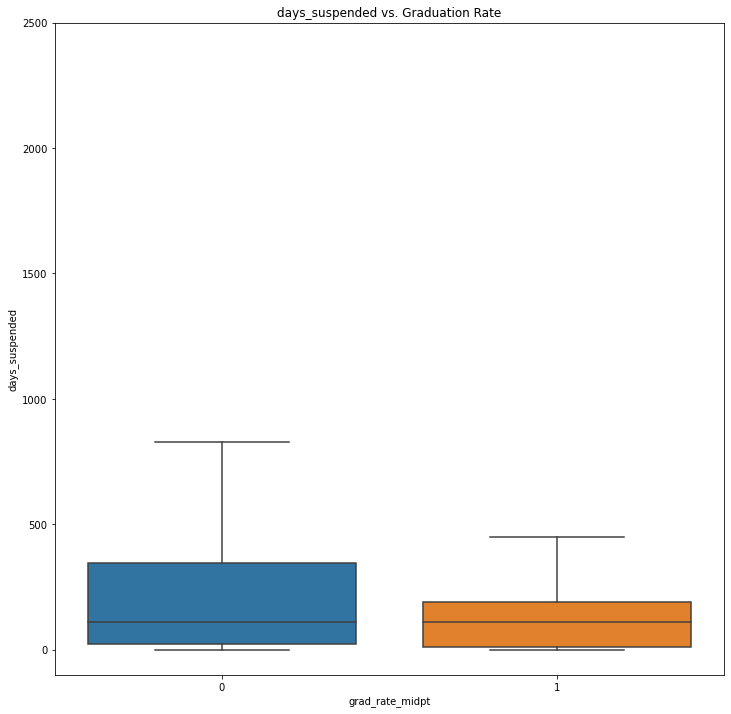

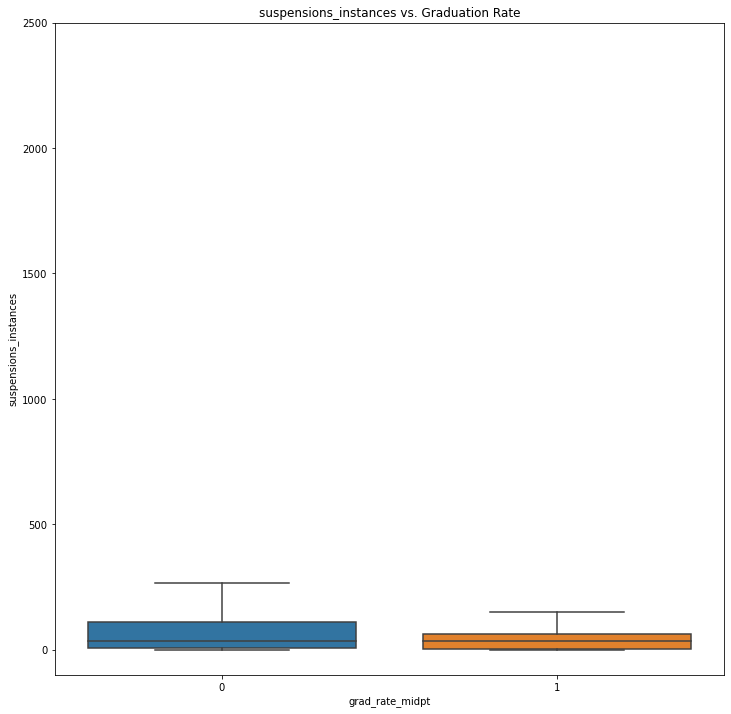

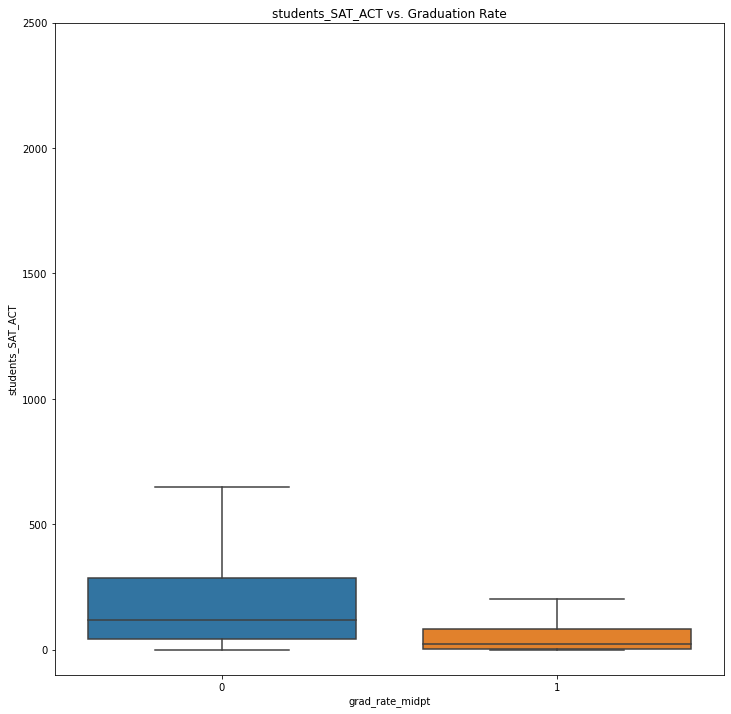

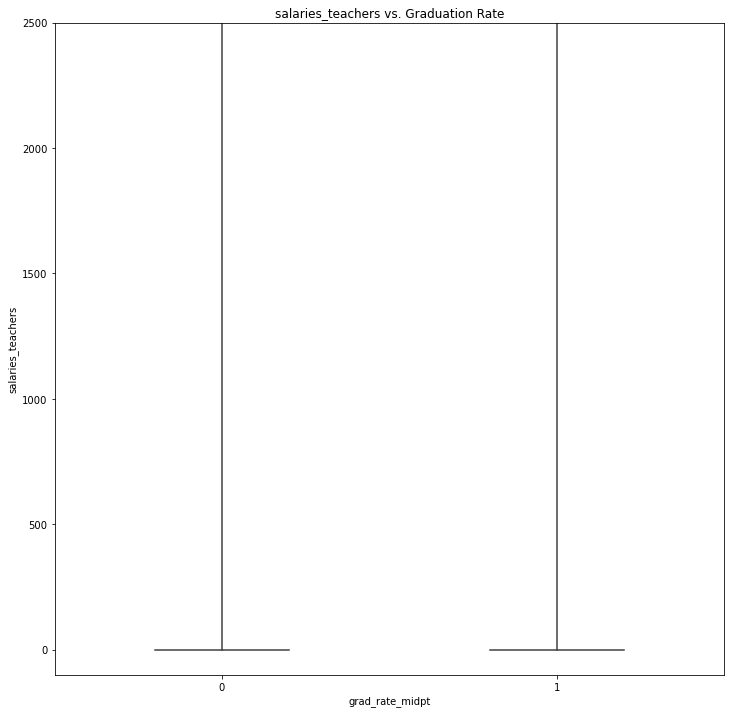

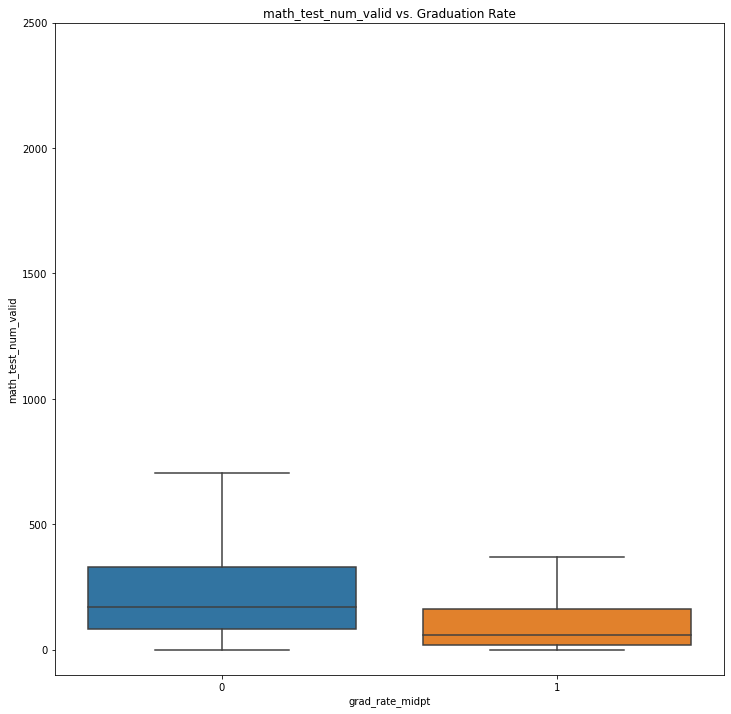

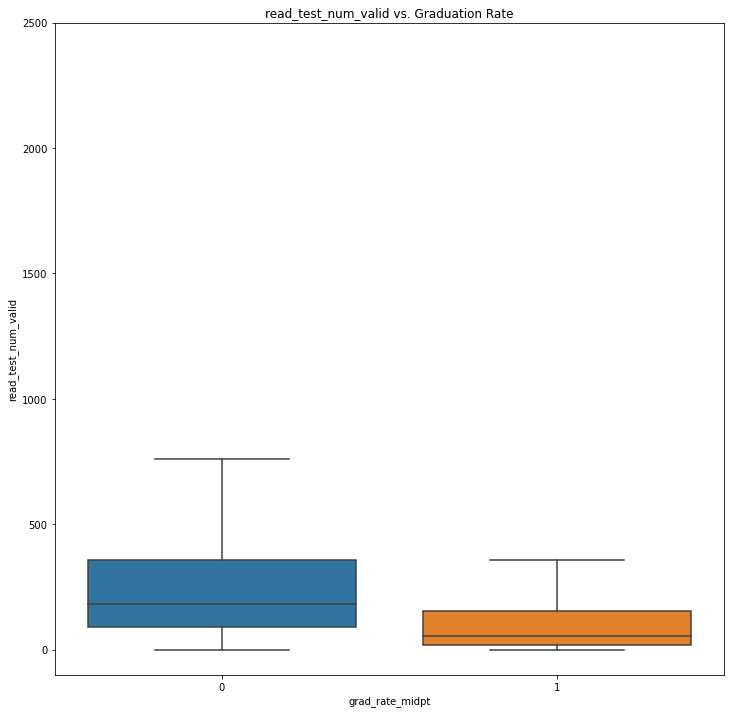

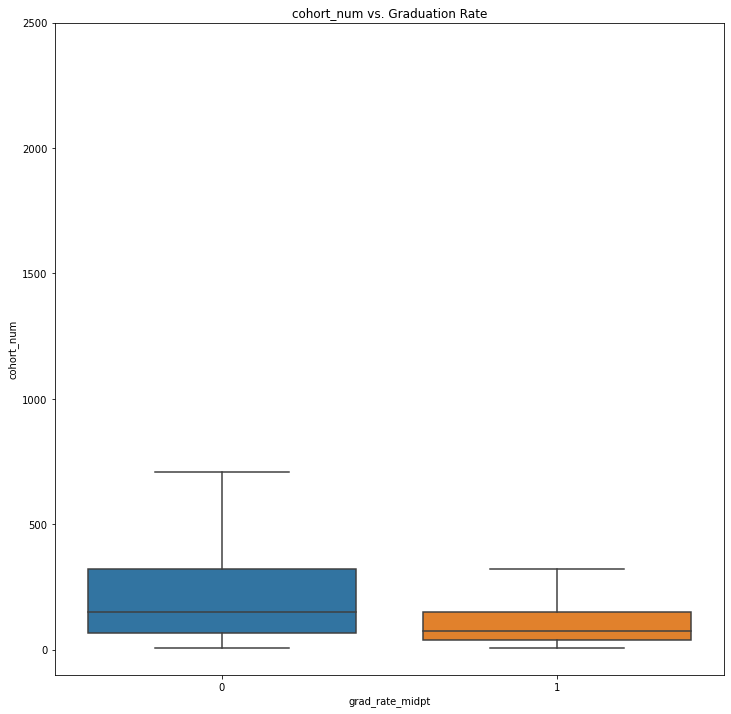

In [89]:
for variable in graph_feats:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(-100,2500)
    sns.boxplot(x='grad_rate_midpt', y=variable, data=df_school, showfliers=False)
    plt.title("{} vs. Graduation Rate".format(variable))

In [90]:
numerical_teacher = ['salaries_teachers']

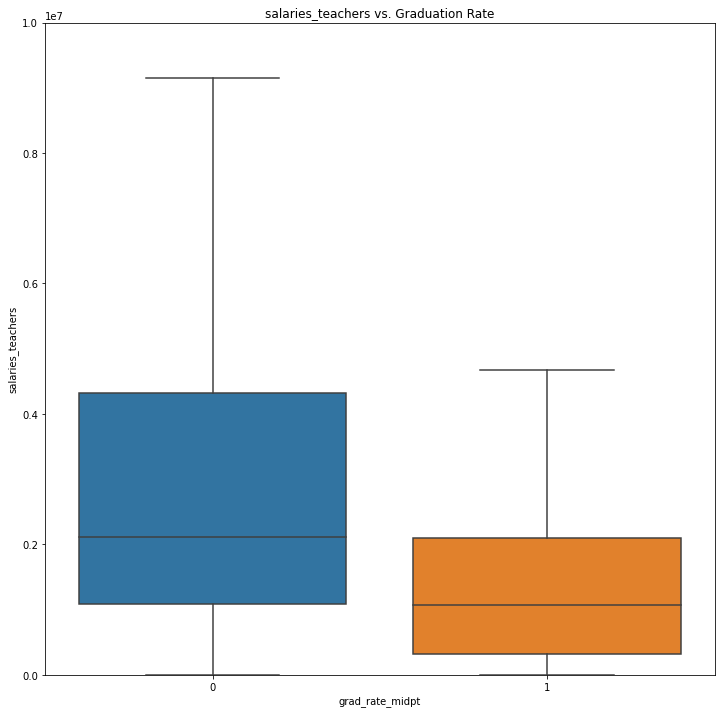

In [91]:
for variable in numerical_teacher:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(-100,10000000)
    sns.boxplot(x='grad_rate_midpt', y=variable, data=df_school, showfliers=False)
    plt.title("{} vs. Graduation Rate".format(variable))

In [92]:
graph_feats = ['days_suspended','suspensions_instances','students_SAT_ACT',
              'salaries_teachers','math_test_num_valid','read_test_num_valid','cohort_num']

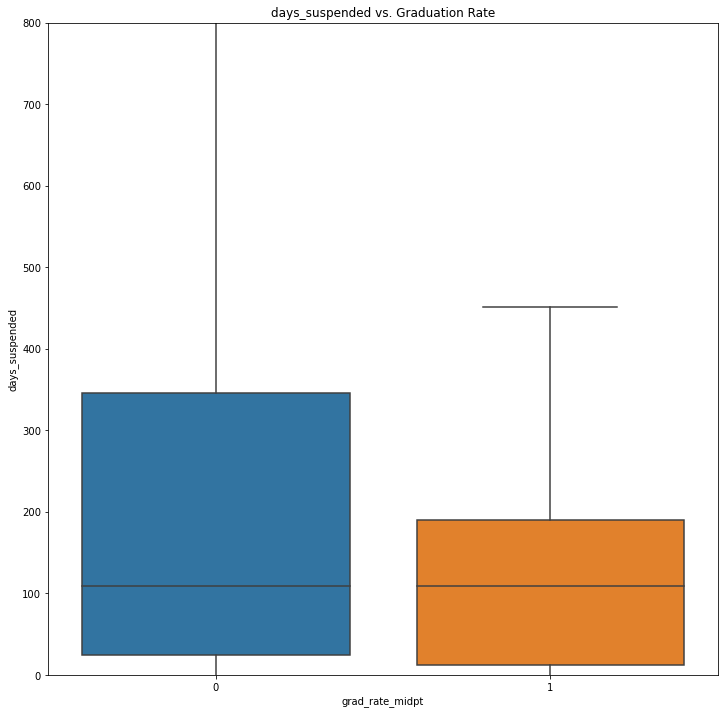

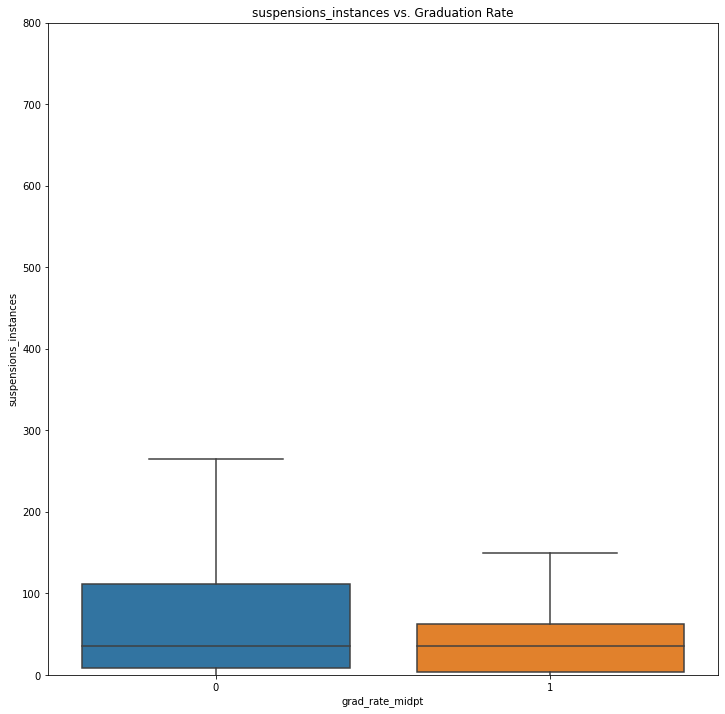

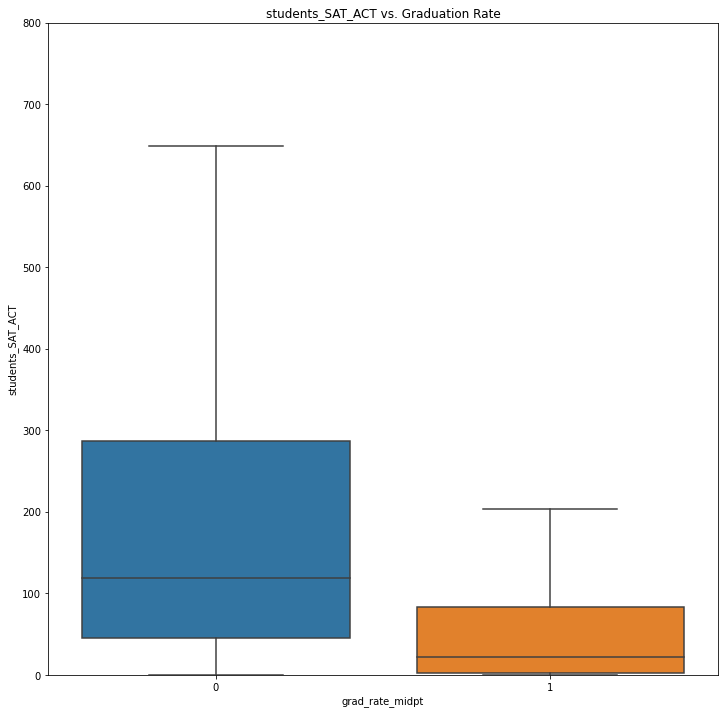

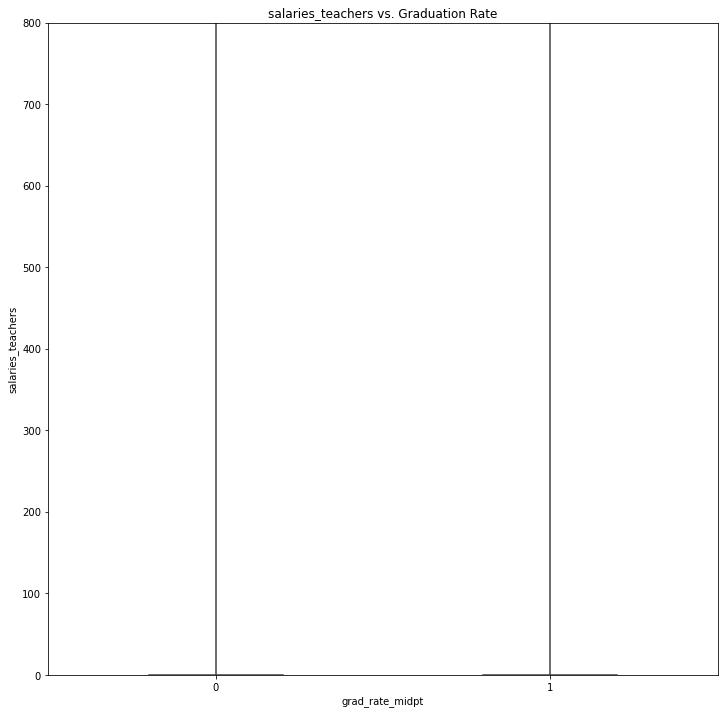

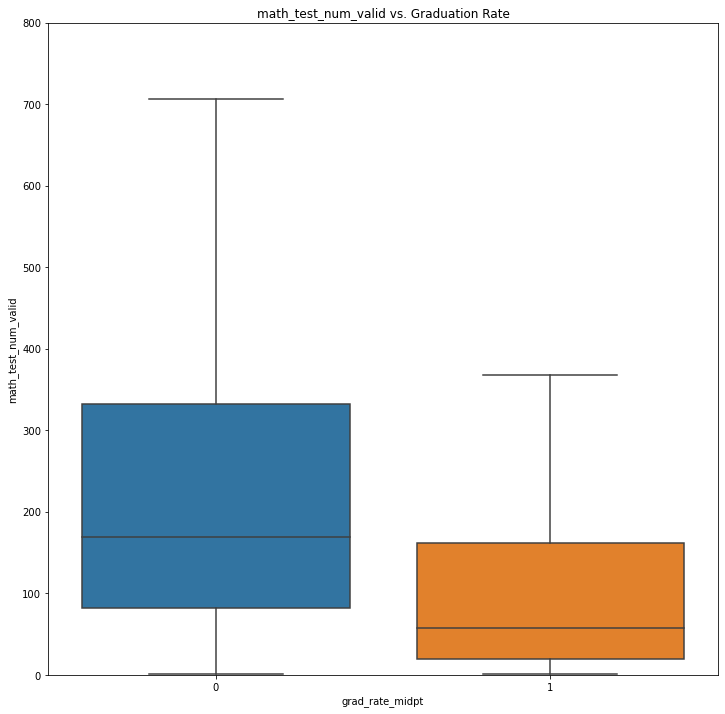

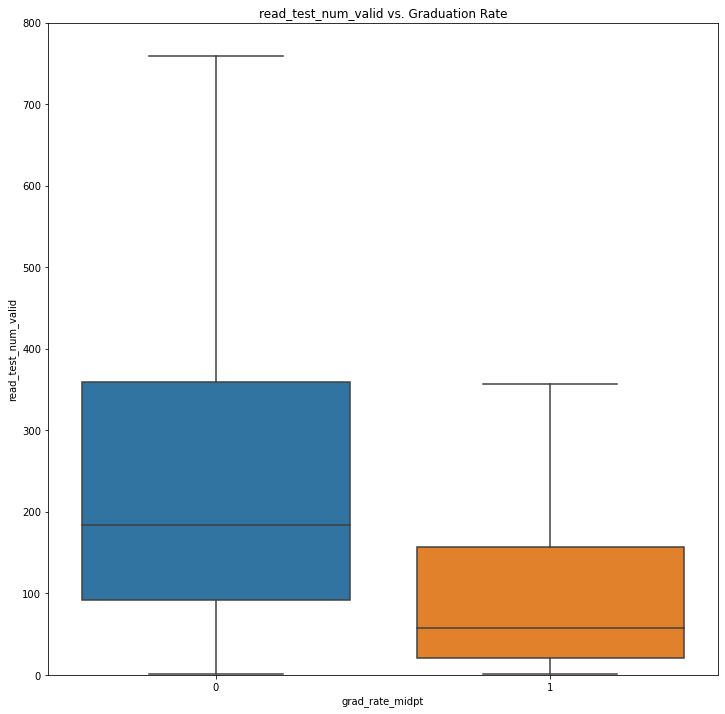

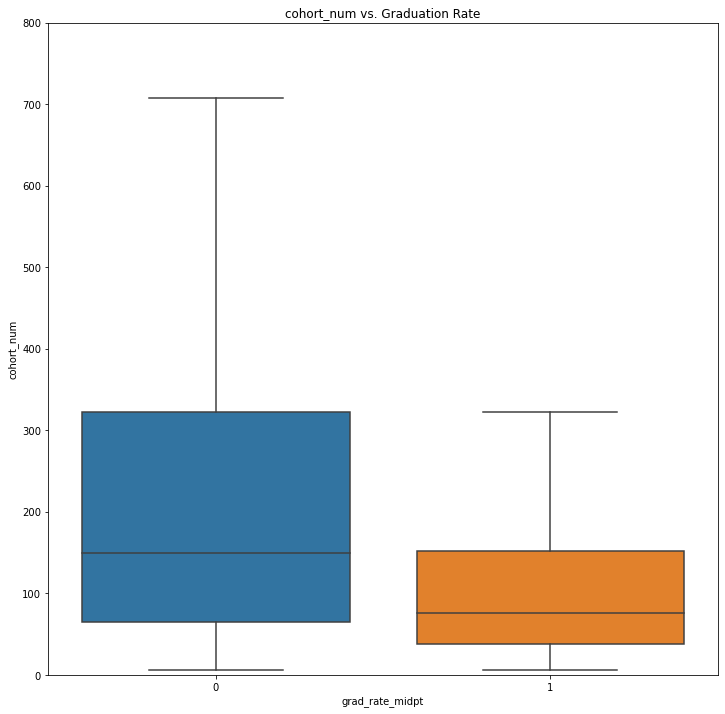

In [93]:
for variable in graph_feats:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(0,800)
    sns.boxplot(x='grad_rate_midpt', y=variable, data=df_school, showfliers=False)
    plt.title("{} vs. Graduation Rate".format(variable))

## df_district

In [94]:
#Concatenate district info for all three states into one dataframe
df_district = pd.concat([df_district_northeast, df_district_south_atl, 
                         df_district_midwest, df_district_west, df_district_south_central])

In [95]:
df_district['state_name'].value_counts(normalize=True, dropna=False)

Texas                   0.067443
California              0.062879
Ohio                    0.060570
Illinois                0.057134
New York                0.055308
Michigan                0.049992
Pennsylvania            0.042958
Arizona                 0.038125
New Jersey              0.037427
Oklahoma                0.032594
Minnesota               0.031305
Missouri                0.030768
Montana                 0.026687
Wisconsin               0.025345
Indiana                 0.023090
Massachusetts           0.021962
Vermont                 0.019492
Iowa                    0.018633
Washington              0.017720
Kansas                  0.017022
North Carolina          0.016968
New Hampshire           0.016109
Arkansas                0.015626
Nebraska                0.015250
Maine                   0.014391
Colorado                0.014230
North Dakota            0.012189
Georgia                 0.011974
Virginia                0.011974
Louisiana               0.011974
Oregon    

### Data Fields

In [96]:
df_district.head()

,year,leaid,lea_name,state_name,state_leaid,city_location,urban_centric_locale,agency_type,enrollment,english_language_learners,...,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,salaries_total,salaries_instruction,benefits_employee_total,cohort_num,grad_rate_high,grad_rate_low,grad_rate_midpt
0,2015,900001,UNIFIED SCHOOL DISTRICT #3,Connecticut,349,HARTFORD,"City, midsize",State-operated agency,NaN,NaN,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,NaN,NaN,NaN,NaN
1,2015,900002,Connecticut Technical High Sc,Connecticut,900,MIDDLETOWN,"Suburb, large",State-operated agency,10710,374,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,2471.0,97,97,97
2,2015,900003,UNIFIED SCHOOL DISTRICT #1,Connecticut,336,WETHERSFIELD,"Suburb, large",State-operated agency,390,12,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,341.0,2,2,2
3,2015,900004,UNIFIED SCHOOL DISTRICT #2,Connecticut,347,HARTFORD,"City, small",State-operated agency,151,Missing/not reported,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,49.0,29,20,24
4,2015,900005,REGIONAL SCHOOL DISTRICT 19,Connecticut,219,STORRS,"Suburb, large",Regular local school district,1206,19,...,151000,203000,0,12377000,8867000,5745000,288.0,92,92,92


In [97]:
df_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18623 entries, 0 to 3049
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             18623 non-null  int64  
 1   leaid                            18623 non-null  int64  
 2   lea_name                         18623 non-null  object 
 3   state_name                       18623 non-null  object 
 4   state_leaid                      18623 non-null  object 
 5   city_location                    18623 non-null  object 
 6   urban_centric_locale             18592 non-null  object 
 7   agency_type                      18623 non-null  object 
 8   enrollment                       17346 non-null  object 
 9   english_language_learners        17346 non-null  object 
 10  est_population_total             13111 non-null  float64
 11  est_population_5_17_poverty      13111 non-null  float64
 12  est_population_5_17

In [98]:
#What proportion of our data frame is nulls?
percent_null_df(df_district,'df_district')

'percent of nulls in df_district is 4%'

#### Data Field Cleanup

In [99]:
column_names = list(df_district.columns)

In [100]:
categorical = ['year','leaid','leaname','state_name','state_leaid','city_location',
               'urban_centric_locale','agency_type']


In [101]:
for ele in categorical:
    try:
        column_names.remove(ele)
    except ValueError:
        pass

In [102]:
numerical = column_names

In [103]:
column_names = list(df_district.columns)

In [104]:
for c in column_names:
    df_district[c].replace('Suppressed data', np.NaN,inplace =True)

In [105]:
for c in column_names:
    df_district[c].replace('Not applicable', np.NaN,inplace =True)

In [106]:
for c in column_names:
    df_district[c].replace('Missing/not reported', np.NaN,inplace =True)

### Columns to drop

In [107]:
df_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18623 entries, 0 to 3049
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             18623 non-null  int64  
 1   leaid                            18623 non-null  int64  
 2   lea_name                         18623 non-null  object 
 3   state_name                       18623 non-null  object 
 4   state_leaid                      18623 non-null  object 
 5   city_location                    18623 non-null  object 
 6   urban_centric_locale             18592 non-null  object 
 7   agency_type                      18623 non-null  object 
 8   enrollment                       17047 non-null  object 
 9   english_language_learners        12381 non-null  object 
 10  est_population_total             13111 non-null  float64
 11  est_population_5_17_poverty      13111 non-null  float64
 12  est_population_5_17

In [108]:
# Our population columns have the highest proportion of nulls
df_district = df_district.drop(['est_population_total','est_population_5_17_poverty',
                           'est_population_5_17_poverty_pct'], axis=1)

In [109]:
# Drop grad rates and urban centric locale: 
# we don't want to delete any districts and are using grad rate and urban centric locale at school level
df_district = df_district.drop(['grad_rate_high','grad_rate_low',
                                'grad_rate_midpt','cohort_num','urban_centric_locale','city_location'], axis=1)

In [110]:
df_district['enrollment'].value_counts(normalize=True, dropna=False)

NaN      0.084627
0        0.020459
177      0.001557
202      0.001450
147      0.001289
           ...   
83648    0.000054
4334     0.000054
8824     0.000054
23529    0.000054
4308     0.000054
Name: enrollment, Length: 5443, dtype: float64

In [111]:
# Enrollment is mostly zeros or NaNs 
df_district = df_district.drop(['enrollment'], axis=1)

In [112]:
# year is the same for all rows, state_name same in school data, state_leaid unnecessary
df_district = df_district.drop(['year','state_name','state_leaid'], axis=1)

In [113]:
#What proportion of our data frame is nulls?
percent_null_df(df_district,'df_district')

'percent of nulls in df_district is 9%'

### english_language_learners

In [114]:
df_district['english_language_learners'].value_counts(normalize=True, dropna=False)

NaN      0.335177
3        0.102669
4        0.021694
0        0.020459
5        0.018955
           ...   
5423     0.000054
1553     0.000054
1996     0.000054
13796    0.000054
675      0.000054
Name: english_language_learners, Length: 1581, dtype: float64

In [115]:
ell = ['english_language_learners']

In [116]:
for c in ell:
    df_district[c].replace('Missing/not reported', np.NaN,inplace =True)

In [117]:
df_district['english_language_learners'].value_counts(normalize=True, dropna=False)

NaN      0.335177
3        0.102669
4        0.021694
0        0.020459
5        0.018955
           ...   
5423     0.000054
1553     0.000054
1996     0.000054
13796    0.000054
675      0.000054
Name: english_language_learners, Length: 1581, dtype: float64

In [118]:
# fill na with median
df_district['english_language_learners'] = df_district['english_language_learners'].fillna(df_district['english_language_learners'].median())

In [119]:
df_district['english_language_learners'].value_counts(normalize=True, dropna=False)

26.0     0.335177
3        0.102669
4        0.021694
0        0.020459
5        0.018955
           ...   
735      0.000054
62575    0.000054
2085     0.000054
991      0.000054
1812     0.000054
Name: english_language_learners, Length: 1581, dtype: float64

In [120]:
df_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18623 entries, 0 to 3049
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   leaid                           18623 non-null  int64 
 1   lea_name                        18623 non-null  object
 2   agency_type                     18623 non-null  object
 3   english_language_learners       18623 non-null  object
 4   rev_total                       16883 non-null  object
 5   rev_fed_total                   16883 non-null  object
 6   rev_state_total                 16883 non-null  object
 7   rev_local_total                 16883 non-null  object
 8   rev_local_prop_tax              12577 non-null  object
 9   exp_total                       16883 non-null  object
 10  exp_current_elsec_total         16883 non-null  object
 11  exp_current_instruction_total   16883 non-null  object
 12  exp_current_supp_serve_total    16883 non-null 

In [121]:
df_district = df_district.drop_duplicates(subset=['lea_name'])

# Join Datasets

In [122]:
df_school.shape

(15829, 47)

In [123]:
df_district.shape

(18257, 42)

In [124]:
# Columns to drop 
df_school = df_school.drop(['ncessch','school_level','school_type','school_name','suspensions_instances_preschool'], axis=1)

In [125]:
df_train = df_school.merge(df_district, on = 'lea_name')
df_train.head()

,state_name,lea_name,urban_centric_locale,charter,enrollment,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,students_susp_in_sch,...,exp_tech_equipment,outlay_capital_total,outlay_capital_construction,outlay_capital_land_structures,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,salaries_total,salaries_instruction,benefits_employee_total
0,Connecticut,REGIONAL SCHOOL DISTRICT 19,"Suburb, large",0.0,1153,260,82,260,55,35,...,0,354000,0,0,151000,203000,0,12377000,8867000,5745000
1,Connecticut,COMMON GROUND HIGH SCHOOL DIS,"City, midsize",1.0,186,39,34,39,5,6,...,0,6558000,6558000,0,0,0,0,1773000,944000,311000
2,Connecticut,THE BRIDGE ACADEMY DISTRICT,"City, midsize",1.0,279,139,22,139,7,25,...,0,712000,659000,0,14000,39000,0,2368000,1615000,473000
3,Connecticut,EXPLORATIONS DISTRICT,"Town, fringe",1.0,92,21,30,21,10,10,...,0,214000,0,0,0,214000,0,773000,521000,118000
4,Connecticut,Stamford Academy,"City, midsize",1.0,150,25,10,25,10,23,...,0,0,0,0,0,0,0,1710000,777000,359000


In [126]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15785 entries, 0 to 15784
Data columns (total 83 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   state_name                      15785 non-null  object 
 1   lea_name                        15785 non-null  object 
 2   urban_centric_locale            15785 non-null  object 
 3   charter                         15785 non-null  float64
 4   enrollment                      15785 non-null  int64  
 5   read_test_num_valid             15785 non-null  int64  
 6   read_test_pct_prof_midpt        15785 non-null  int64  
 7   math_test_num_valid             15785 non-null  int64  
 8   math_test_pct_prof_midpt        15785 non-null  int64  
 9   students_susp_in_sch            15785 non-null  int64  
 10  students_susp_out_sch_single    15785 non-null  int64  
 11  students_susp_out_sch_multiple  15785 non-null  int64  
 12  expulsions_no_ed_serv           

In [127]:
# Columns to drop - we don't need these anymore 
df_train = df_train.drop(['leaid','lea_name'], axis=1)

## Check for NaNs

In [128]:
nan_values = df_train.isna()
nan_columns = nan_values.any()

In [129]:
columns_with_nan = df_train.columns[nan_columns].tolist()
print(columns_with_nan)

['rev_total', 'rev_fed_total', 'rev_state_total', 'rev_local_total', 'rev_local_prop_tax', 'exp_total', 'exp_current_elsec_total', 'exp_current_instruction_total', 'exp_current_supp_serve_total', 'exp_current_pupils', 'exp_current_instruc_staff', 'exp_current_general_admin', 'exp_current_sch_admin', 'exp_current_operation_plant', 'exp_current_student_transport', 'exp_current_bco', 'exp_current_supp_serv_nonspec', 'exp_current_other', 'exp_current_food_serv', 'exp_current_enterprise', 'exp_current_other_elsec', 'exp_nonelsec', 'exp_nonelsec_community_serv', 'exp_nonelsec_adult_education', 'exp_nonelsec_other', 'exp_textbooks', 'exp_utilities_energy', 'exp_tech_supplies_services', 'exp_tech_equipment', 'outlay_capital_total', 'outlay_capital_construction', 'outlay_capital_land_structures', 'outlay_capital_instruc_equip', 'outlay_capital_other_equip', 'outlay_capital_nonspec_equip', 'salaries_total', 'salaries_instruction', 'benefits_employee_total']


We still have NaN values in our numerical fields

# Numeric Columns - cleanup

## Cleanup

In [130]:
col_names_category = ['state_name','urban_centric_locale',
                      'agency_type','grad_rate_midpt']

In [131]:
col_names = list(df_train.columns)

In [132]:
num_col_names = set(col_names) - set(col_names_category)
num_col_names = list(num_col_names)

In [133]:
df_train[num_col_names] = df_train[num_col_names].fillna(df_train[num_col_names].median())

In [134]:
df_train[num_col_names] = df_train[num_col_names].astype(str).astype(float).astype(int)

## Engineer % Columns

In [135]:
df_train['SAT_ACT_%_enrollment'] = df_train['students_SAT_ACT'] / df_train['enrollment'] * 100

In [136]:
df_train['teacher_%_total_salary'] =  df_train['salaries_instruction'] / df_train['salaries_total'] * 100
df_train.head()

,state_name,urban_centric_locale,charter,enrollment,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,students_susp_in_sch,students_susp_out_sch_single,...,outlay_capital_construction,outlay_capital_land_structures,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,salaries_total,salaries_instruction,benefits_employee_total,SAT_ACT_%_enrollment,teacher_%_total_salary
0,Connecticut,"Suburb, large",0,1153,260,82,260,55,35,28,...,0,0,151000,203000,0,12377000,8867000,5745000,36.426713,71.640947
1,Connecticut,"City, midsize",1,186,39,34,39,5,6,14,...,6558000,0,0,0,0,1773000,944000,311000,23.118280,53.243091
2,Connecticut,"City, midsize",1,279,139,22,139,7,25,18,...,659000,0,14000,39000,0,2368000,1615000,473000,29.032258,68.201014
3,Connecticut,"Town, fringe",1,92,21,30,21,10,10,15,...,0,0,0,214000,0,773000,521000,118000,28.260870,67.399741
4,Connecticut,"City, midsize",1,150,25,10,25,10,23,22,...,0,0,0,0,0,1710000,777000,359000,74.666667,45.438596


In [137]:
pct_graph = ['SAT_ACT_%_enrollment','teacher_%_total_salary','read_test_pct_prof_midpt','math_test_pct_prof_midpt']

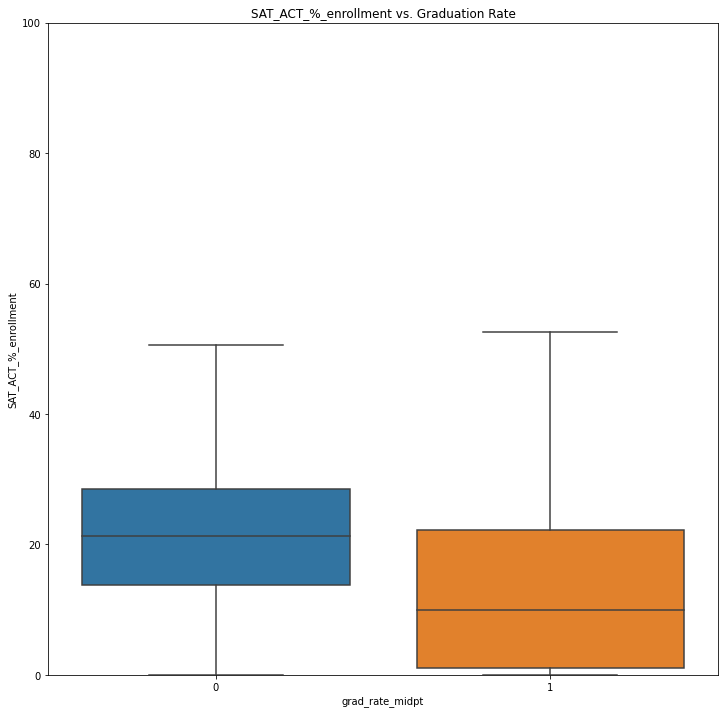

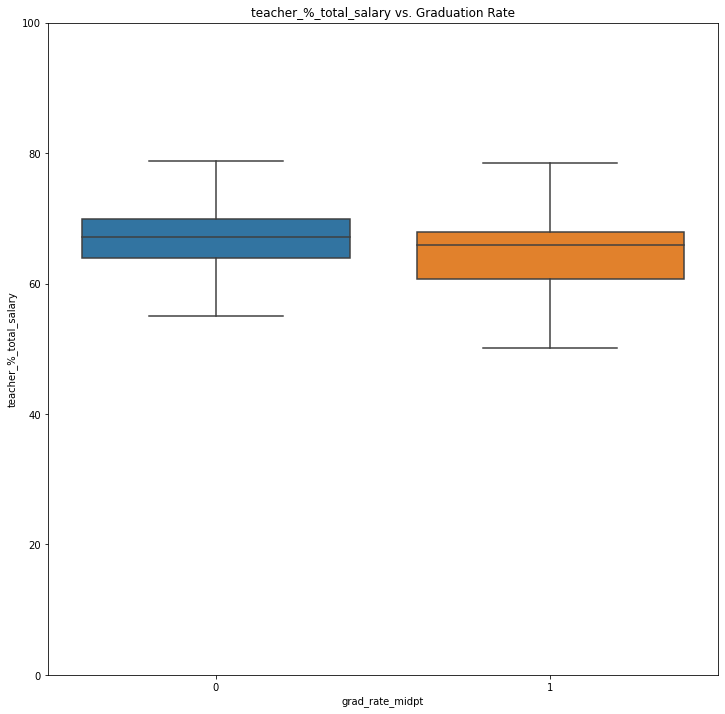

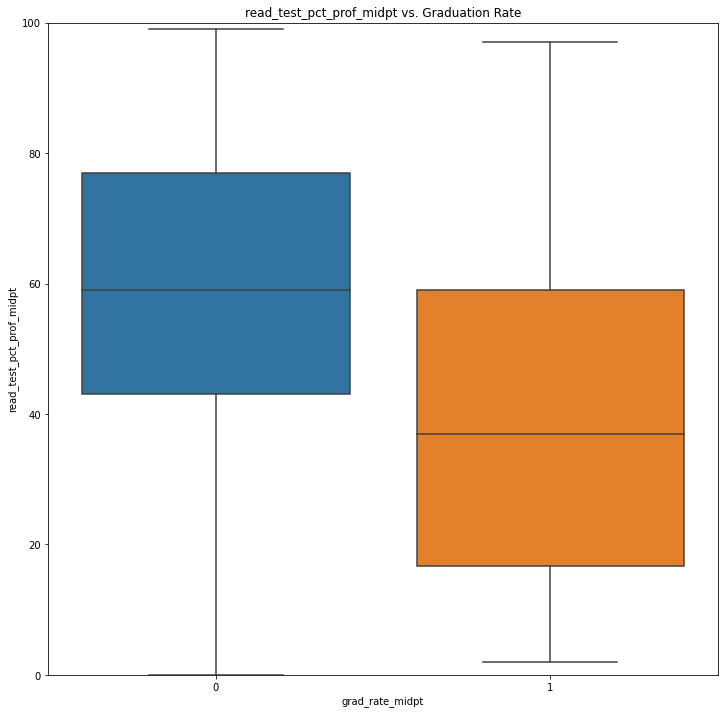

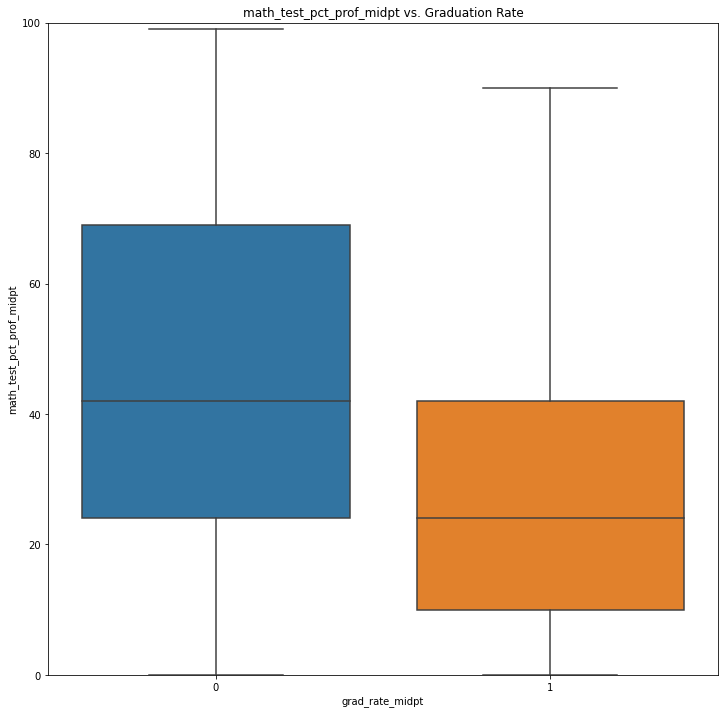

In [138]:
for variable in pct_graph:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(0,100)
    sns.boxplot( x='grad_rate_midpt', y=variable, data=df_train, showfliers=False)
    plt.title("{} vs. Graduation Rate".format(variable))

In [139]:
df_train = df_train.drop(['salaries_instruction','salaries_total','students_SAT_ACT'], axis=1)

## Reset Num List

In [140]:
col_names_category = ['state_name','urban_centric_locale',
                      'agency_type','grad_rate_midpt']

In [141]:
col_names = list(df_train.columns)

In [142]:
num_col_names = set(col_names) - set(col_names_category)
num_col_names = list(num_col_names)

In [143]:
df_train[num_col_names] = df_train[num_col_names].fillna(df_train[num_col_names].median())

In [144]:
df_train[num_col_names] = df_train[num_col_names].astype(str).astype(float).astype(int)

# Category Columns - cleanup

In [145]:
df_train[col_names_category] = df_train[col_names_category].astype('category')

In [146]:
col_names_ohe = ['state_name','urban_centric_locale',
                 'agency_type']

In [147]:
df_train[col_names_ohe] = df_train[col_names_ohe].astype(str)

In [148]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15785 entries, 0 to 15784
Data columns (total 80 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   state_name                      15785 non-null  object  
 1   urban_centric_locale            15785 non-null  object  
 2   charter                         15785 non-null  int64   
 3   enrollment                      15785 non-null  int64   
 4   read_test_num_valid             15785 non-null  int64   
 5   read_test_pct_prof_midpt        15785 non-null  int64   
 6   math_test_num_valid             15785 non-null  int64   
 7   math_test_pct_prof_midpt        15785 non-null  int64   
 8   students_susp_in_sch            15785 non-null  int64   
 9   students_susp_out_sch_single    15785 non-null  int64   
 10  students_susp_out_sch_multiple  15785 non-null  int64   
 11  expulsions_no_ed_serv           15785 non-null  int64   
 12  expulsions_with_ed

## Final Check for NaNs

In [149]:
nan_values = df_train.isna()
nan_columns = nan_values.any()

In [150]:
columns_with_nan = df_train.columns[nan_columns].tolist()
print(columns_with_nan)

[]


# Train Test Split

In [151]:
X=df_train.drop(columns = ['grad_rate_midpt']) # Features
y=df_train['grad_rate_midpt'] #Target

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [153]:
X_train

,state_name,urban_centric_locale,charter,enrollment,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,students_susp_in_sch,students_susp_out_sch_single,...,exp_tech_equipment,outlay_capital_total,outlay_capital_construction,outlay_capital_land_structures,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,benefits_employee_total,SAT_ACT_%_enrollment,teacher_%_total_salary
7105,Minnesota,"Rural, distant",0,183,96,47,87,52,32,4,...,0,532000,315000,0,5000,212000,0,1145000,9,62
13034,Alabama,"Town, distant",0,241,50,15,50,5,69,6,...,0,232000,232000,0,0,0,0,2006000,34,64
6979,Michigan,"Suburb, small",0,1265,300,64,300,26,0,0,...,0,1461000,440000,376000,0,645000,0,29467000,23,71
9785,Arizona,"Town, fringe",1,121,7,24,11,24,0,5,...,0,120000,0,75000,0,0,45000,757000,0,72
6744,Michigan,"City, large",0,269,44,15,44,5,0,55,...,0,4922000,370000,778000,413000,3361000,0,174513000,11,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7404,Minnesota,"Town, distant",0,992,243,61,220,34,145,11,...,0,25195000,23786000,0,232000,1177000,0,6097000,27,70
10737,California,"Suburb, large",0,1377,312,54,309,19,4,4,...,0,582529000,567307000,1457000,1245000,12520000,0,2241567000,18,62
11490,Colorado,"City, large",1,501,177,17,174,17,65,32,...,9566000,164279000,91680000,42049000,11220000,19330000,0,175764000,17,53
12604,Washington,"Town, distant",0,713,163,82,151,42,0,24,...,0,994000,690000,36000,25000,243000,0,6005000,0,58


In [154]:
X_train.shape

(11049, 79)

In [155]:
X_test.shape

(4736, 79)

# Encode Features

In [156]:
# define transformers
ss = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False,)
# set up pipelines for each column group
numeric_pipe = Pipeline([('ss', ss)])
categorical_pipe = Pipeline([('ohe', ohe)])
# set up columnTransformer
col_transformer = ColumnTransformer(
                    transformers=[
                        ('nums', numeric_pipe, num_col_names),
                        ('cats', categorical_pipe, col_names_ohe),                        
                    ],
                    remainder='drop',
                    n_jobs=-1
                    )

## X_train Encode

In [157]:
X_train = col_transformer.fit_transform(X_train)

In [158]:
col_transformer.named_transformers_['cats'].named_steps['ohe']\
     .get_feature_names()

array(['x0_Alabama', 'x0_Arizona', 'x0_Arkansas', 'x0_California',
       'x0_Colorado', 'x0_Connecticut', 'x0_Delaware',
       'x0_District of Columbia', 'x0_Florida', 'x0_Georgia', 'x0_Idaho',
       'x0_Illinois', 'x0_Indiana', 'x0_Iowa', 'x0_Kansas', 'x0_Kentucky',
       'x0_Louisiana', 'x0_Maine', 'x0_Maryland', 'x0_Massachusetts',
       'x0_Michigan', 'x0_Minnesota', 'x0_Mississippi', 'x0_Missouri',
       'x0_Montana', 'x0_Nebraska', 'x0_Nevada', 'x0_New Hampshire',
       'x0_New Jersey', 'x0_New Mexico', 'x0_New York',
       'x0_North Carolina', 'x0_North Dakota', 'x0_Ohio', 'x0_Oklahoma',
       'x0_Oregon', 'x0_Pennsylvania', 'x0_Rhode Island',
       'x0_South Carolina', 'x0_South Dakota', 'x0_Tennessee', 'x0_Texas',
       'x0_Utah', 'x0_Vermont', 'x0_Virginia', 'x0_Washington',
       'x0_West Virginia', 'x0_Wisconsin', 'x0_Wyoming', 'x1_City, large',
       'x1_City, midsize', 'x1_City, small', 'x1_Rural, distant',
       'x1_Rural, fringe', 'x1_Rural, remote', 'x1_S

In [159]:
X_train.shape

(11049, 144)




## X_test Encode

In [160]:
X_test = col_transformer.transform(X_test)

In [161]:
col_transformer.named_transformers_['cats'].named_steps['ohe']\
     .get_feature_names()

array(['x0_Alabama', 'x0_Arizona', 'x0_Arkansas', 'x0_California',
       'x0_Colorado', 'x0_Connecticut', 'x0_Delaware',
       'x0_District of Columbia', 'x0_Florida', 'x0_Georgia', 'x0_Idaho',
       'x0_Illinois', 'x0_Indiana', 'x0_Iowa', 'x0_Kansas', 'x0_Kentucky',
       'x0_Louisiana', 'x0_Maine', 'x0_Maryland', 'x0_Massachusetts',
       'x0_Michigan', 'x0_Minnesota', 'x0_Mississippi', 'x0_Missouri',
       'x0_Montana', 'x0_Nebraska', 'x0_Nevada', 'x0_New Hampshire',
       'x0_New Jersey', 'x0_New Mexico', 'x0_New York',
       'x0_North Carolina', 'x0_North Dakota', 'x0_Ohio', 'x0_Oklahoma',
       'x0_Oregon', 'x0_Pennsylvania', 'x0_Rhode Island',
       'x0_South Carolina', 'x0_South Dakota', 'x0_Tennessee', 'x0_Texas',
       'x0_Utah', 'x0_Vermont', 'x0_Virginia', 'x0_Washington',
       'x0_West Virginia', 'x0_Wisconsin', 'x0_Wyoming', 'x1_City, large',
       'x1_City, midsize', 'x1_City, small', 'x1_Rural, distant',
       'x1_Rural, fringe', 'x1_Rural, remote', 'x1_S

In [162]:
X_test.shape

(4736, 144)

In [163]:
X_test.shape

(4736, 144)

# Model Development

## Logistic Regression

In [164]:
# Logistic model
log_clf = LogisticRegression(class_weight='balanced')
log_model = log_clf.fit(X_train, y_train)
y_pred_train = log_model.predict(X_train)
y_pred = log_model.predict(X_test)

In [165]:
#Confusion matrix for Logistic Regression
log_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', log_matrix)

Confusion Matrix:
 [[3926  466]
 [  54  290]]


In [166]:
print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
print('The f1 score for the model is:',f1_score(y_test, y_pred))

The f1 score for the training model is: 0.5368209255533198
The f1 score for the model is: 0.5272727272727273


In [167]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.99      0.89      0.94      4392
   low grad rate       0.38      0.84      0.53       344

        accuracy                           0.89      4736
       macro avg       0.69      0.87      0.73      4736
    weighted avg       0.94      0.89      0.91      4736



### Check for Overfit

In [168]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

array([[9231, 1082],
       [  69,  667]])

In [169]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[3926,  466],
       [  54,  290]])

In [170]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.99      0.90      0.94     10313
   low grad rate       0.38      0.91      0.54       736

        accuracy                           0.90     11049
       macro avg       0.69      0.90      0.74     11049
    weighted avg       0.95      0.90      0.91     11049



In [171]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.99      0.89      0.94      4392
   low grad rate       0.38      0.84      0.53       344

        accuracy                           0.89      4736
       macro avg       0.69      0.87      0.73      4736
    weighted avg       0.94      0.89      0.91      4736



### Model reiteration - parameter tuning

In [172]:
# Logistic model
log_clf = LogisticRegression( class_weight='balanced')
log_model = log_clf.fit(X_train, y_train)
y_pred_train = log_model.predict(X_train)
y_pred = log_model.predict(X_test)

In [173]:
model_params = {
    #Algorithm to use in the optimization problem
    'solver': ['newton-cg', 'sag', 'saga','lbfgs'],
    # Maximum number of iterations taken for the solvers to converge
    'max_iter': [10,50,100],
    # random state
    'random_state': [1]
}

In [174]:
# Instantiate and fit the LogisticReg Model
log_clf = LogisticRegression(class_weight='balanced')
log_clf = GridSearchCV(log_clf,model_params,scoring = 'recall')
log_clf.fit(X_train,y_train)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'max_iter': [10, 50, 100], 'random_state': [1],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
             scoring='recall')

In [175]:
LogisticRegression(class_weight='balanced').get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [176]:
print(log_clf.best_estimator_.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [177]:
print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
print('The f1 score for the model is:',f1_score(y_test, y_pred))

The f1 score for the training model is: 0.5368209255533198
The f1 score for the model is: 0.5272727272727273


In [178]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.99      0.90      0.94     10313
   low grad rate       0.38      0.91      0.54       736

        accuracy                           0.90     11049
       macro avg       0.69      0.90      0.74     11049
    weighted avg       0.95      0.90      0.91     11049



In [179]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.99      0.89      0.94      4392
   low grad rate       0.38      0.84      0.53       344

        accuracy                           0.89      4736
       macro avg       0.69      0.87      0.73      4736
    weighted avg       0.94      0.89      0.91      4736



## Random Forest Classifier

In [180]:
# Instantiate and fit the RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=10,class_weight='balanced')
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=10)

In [181]:
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_pred = rfc.predict(X_test)
y_pred_train = rfc.predict(X_train)
prediction_end = time.perf_counter()
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 94.83
Time consumed for training: 0.239 seconds
Time consumed for prediction: 0.02154 seconds


In [182]:
print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
print('The f1 score for the model is:',f1_score(y_test, y_pred))

The f1 score for the training model is: 0.9560906515580737
The f1 score for the model is: 0.5279383429672447


In [183]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.95      0.99      0.97      4392
   low grad rate       0.78      0.40      0.53       344

        accuracy                           0.95      4736
       macro avg       0.87      0.69      0.75      4736
    weighted avg       0.94      0.95      0.94      4736



### Check for Overfit

In [184]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

array([[10312,     1],
       [   61,   675]])

In [185]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[4354,   38],
       [ 207,  137]])

In [186]:
rfc_training_preds = rfc.predict(X_train)
rfc_training_f1 = f1_score(y_train, rfc_training_preds)

rfc_val_preds = rfc.predict(X_test) # y_hat
rfc_val_f1 = f1_score(y_test, rfc_val_preds)
print(rfc_training_f1)
print(rfc_val_f1)

0.9560906515580737
0.5279383429672447


In [187]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1], 
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.99      1.00      1.00     10313
   low grad rate       1.00      0.92      0.96       736

        accuracy                           0.99     11049
       macro avg       1.00      0.96      0.98     11049
    weighted avg       0.99      0.99      0.99     11049



In [188]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                   target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.95      0.99      0.97      4392
   low grad rate       0.78      0.40      0.53       344

        accuracy                           0.95      4736
       macro avg       0.87      0.69      0.75      4736
    weighted avg       0.94      0.95      0.94      4736



Definitely overfit we see this especially in the low grad rate class

### Feature Importance

In [189]:
# Need to make a list of feature names for feat importance graph 
# Need function since data is in numpy arrays
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [190]:
col_name_num = get_column_names_from_ColumnTransformer(col_transformer)

In [191]:
col_name_cat = list(col_transformer.named_transformers_['cats'].named_steps['ohe']\
     .get_feature_names())

In [192]:
rfc_columns = col_name_num + col_name_cat

<AxesSubplot:>

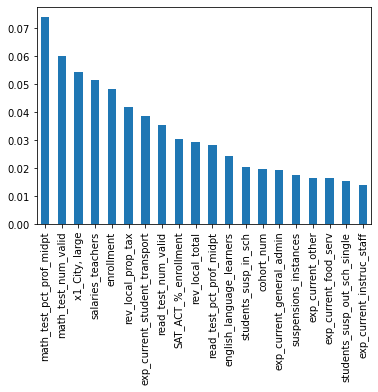

In [193]:
feat_importances = pd.Series(rfc.feature_importances_, index = rfc_columns)
feat_importances.nlargest(20).plot(kind='bar')

### Model reiteration - parameter tuning

In [194]:
model_params = {
    # number of 
    'n_estimators': [5,10,20,50,100,200],
    # number of max features
    'max_features': [10,15,20,50,100],
    # max number of levels in each decision tree
    'max_depth': [5,10,15],
    # minimum amount of samples in a node
    'min_samples_leaf': [10],
    # minimum amount of samples to split
    'min_samples_split' : [100,1000],
    # random state
    'random_state': [1]
    
}

In [195]:
# Instantiate and fit the RandomForestClassifier
rfc=RandomForestClassifier(class_weight='balanced')
rfc = GridSearchCV(rfc, model_params, scoring = 'recall')
rfc.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': [10, 15, 20, 50, 100],
                         'min_samples_leaf': [10],
                         'min_samples_split': [100, 1000],
                         'n_estimators': [5, 10, 20, 50, 100, 200],
                         'random_state': [1]},
             scoring='recall')

In [196]:
print(rfc.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 100, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 10, 'min_samples_split': 1000, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [197]:
print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
print('The f1 score for the model is:',f1_score(y_test, y_pred))

The f1 score for the training model is: 0.9560906515580737
The f1 score for the model is: 0.5279383429672447


In [198]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.99      1.00      1.00     10313
   low grad rate       1.00      0.92      0.96       736

        accuracy                           0.99     11049
       macro avg       1.00      0.96      0.98     11049
    weighted avg       0.99      0.99      0.99     11049



In [199]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.95      0.99      0.97      4392
   low grad rate       0.78      0.40      0.53       344

        accuracy                           0.95      4736
       macro avg       0.87      0.69      0.75      4736
    weighted avg       0.94      0.95      0.94      4736



## Gradient Boosting Classifier

In [200]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
y_pred_train = gb_clf.predict(X_train)

# print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
# print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

In [201]:
print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
print('The f1 score for the model is:',f1_score(y_test, y_pred))

The f1 score for the training model is: 0.7556596409055425
The f1 score for the model is: 0.6079447322970639


In [202]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.96      0.99      0.97      4392
   low grad rate       0.75      0.51      0.61       344

        accuracy                           0.95      4736
       macro avg       0.86      0.75      0.79      4736
    weighted avg       0.95      0.95      0.95      4736



### Check for Overfit

In [203]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

array([[10252,    61],
       [  252,   484]])

In [204]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[4333,   59],
       [ 168,  176]])

In [205]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.98      0.99      0.98     10313
   low grad rate       0.89      0.66      0.76       736

        accuracy                           0.97     11049
       macro avg       0.93      0.83      0.87     11049
    weighted avg       0.97      0.97      0.97     11049



In [206]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.96      0.99      0.97      4392
   low grad rate       0.75      0.51      0.61       344

        accuracy                           0.95      4736
       macro avg       0.86      0.75      0.79      4736
    weighted avg       0.95      0.95      0.95      4736



### Model reiteration - parameter tuning

In [207]:
model_params = {
    # number of boosting stages
    'n_estimators': [5,10,20,50,100,200],
    # number of max features
    'max_features': [10,15,20,50,100],
     # minimum amount of samples in a node
    'min_samples_leaf': [10],
    # Learning rate
    'learning_rate':[.25,.5,.75,1],
    #The minimum number of samples required to split an internal node
    'min_samples_split' : [100,1000],
     # random state
    'random_state':[1]
}

In [208]:
gb_clf = GradientBoostingClassifier()
gb_clf = GridSearchCV(gb_clf,model_params, scoring = 'recall')
gb_clf.fit(X_train,y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.25, 0.5, 0.75, 1],
                         'max_features': [10, 15, 20, 50, 100],
                         'min_samples_leaf': [10],
                         'min_samples_split': [100, 1000],
                         'n_estimators': [5, 10, 20, 50, 100, 200],
                         'random_state': [1]},
             scoring='recall')

In [209]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.98      0.99      0.98     10313
   low grad rate       0.89      0.66      0.76       736

        accuracy                           0.97     11049
       macro avg       0.93      0.83      0.87     11049
    weighted avg       0.97      0.97      0.97     11049



In [210]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

                  precision    recall  f1-score   support

normal grad rate       0.96      0.99      0.97      4392
   low grad rate       0.75      0.51      0.61       344

        accuracy                           0.95      4736
       macro avg       0.86      0.75      0.79      4736
    weighted avg       0.95      0.95      0.95      4736



In [212]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))
    print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
    print('The f1 score for the model is:',f1_score(y_test, y_pred))

Learning rate:  0.05
Accuracy score (training): 0.942
Accuracy score (validation): 0.938
The f1 score for the training model is: 0.7556596409055425
The f1 score for the model is: 0.6079447322970639
Learning rate:  0.075
Accuracy score (training): 0.949
Accuracy score (validation): 0.942
The f1 score for the training model is: 0.7556596409055425
The f1 score for the model is: 0.6079447322970639
Learning rate:  0.1
Accuracy score (training): 0.953
Accuracy score (validation): 0.945
The f1 score for the training model is: 0.7556596409055425
The f1 score for the model is: 0.6079447322970639
Learning rate:  0.25
Accuracy score (training): 0.962
Accuracy score (validation): 0.948
The f1 score for the training model is: 0.7556596409055425
The f1 score for the model is: 0.6079447322970639
Learning rate:  0.5
Accuracy score (training): 0.967
Accuracy score (validation): 0.948
The f1 score for the training model is: 0.7556596409055425
The f1 score for the model is: 0.6079447322970639
Learning ra

# Conclusions

- Our modeling struggles with overfitting and is better at classifying the majority class (normal graduation rate). However, we were able to achieve a high enough performance that we feel confident in making recommendations based on the the features which had the greatest feature importance for our modeling.
- The number of students who completed math and reading tests and received a proficient grade were major indicators for higher graduation rates.
- The number of students participating in ACT/SAT tests was a strong indicator for our model. Higher participation meant higher likelihood of being in a normal graduation rate group.
- Higher % of total salary devoted to teacher salaries was an indicator of normal high school graduation rates.


# Recommendations

- Mathematics and Reading: Focus resources  on providing extra support for mathematics and reading. School districts should investigate the best way to improve these scores whether it be through offering remedial opportunities additional tutoring or increasing testing practice for these specific areas.
- ACT/SAT: As with many education metrics ACT/SAT participation likely also has a relationship with school funding and other types of factors. However, regardless of other factors ACT/SAT prep can be a motivating factor for students even at underfunded schools. With the view that the main goal for students in high school is to prepare themselves so they will be accepted into college
- Teacher Salaries: 
  - This feature may be confounded by other factors. For example a school with less overall funding likely has to devote more salary to maintenance workers if they are unable to receive funding for newer facilities.
  - We do not  recommend making teacher salaries  a higher proportion in budgeting plans as this indicator is likely confounded by other financial factors.

# Future Work

- Perform feature selection steps to improve overfit of the modeling.
- Investigate adding new features. Now that we have a better handle on which types of features are important we should investigate adding new features from our reporting sources and also engineering new features with the data we already have on hand.
- Investigate which types of schools did not report graduation rates. We need to know if we are missing any important type of data for unreported graduation rates. Is the type of schools not reporting graduation rates similar to those that do report?
